In [1]:
from collections import defaultdict
import numpy as np
import tqdm
import networkx as nx
import pandas as pd
import ast
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import Subset

from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

from transformers import GPT2Tokenizer
import statsmodels.api as sm

# GraphSSL was not used in the end but the code is still here as an example
#from GraphSSL.selfsl_augmentation import *
#from GraphSSL.selfsl_loss import *
from dataset import *
from model import *

np.random.seed(39)
device = "cuda" if torch.cuda.is_available() else "cpu"

## Gender Labelling

Using a plain transformer for labelling gender of nodes in MovieGalaxies.

In [2]:
dataset = MovieGalaxiesDataset("data/")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 776/776 [00:14<00:00, 53.35it/s]


In [8]:
num_unknown = 0
num_male = 0
num_female = 0
for i in range(len(dataset)):
    num_unknown += (dataset[i].gender == -1).sum().item()
    num_female += (dataset[i].gender == 0).sum().item()
    num_male += (dataset[i].gender == 1).sum().item()
    
num_unknown, num_male, num_female

(19006, 6457, 2824)

In [13]:
(num_unknown + num_male + num_female)

28287

In [7]:
def train(model, optimizer, batch):
    # clear 
    optimizer.zero_grad()
    
    # forward pass
    if self_supervise:
        out, main_features = model(batch)
    else:
        out = model(batch)
    out = out[(batch.y != -1)].squeeze()
    
    # get labels
    labels = nn.functional.one_hot(batch.y[(batch.y != -1)]).float().to(device)
    
    # self_supervised
    if self_supervise:
        augmented_sample = augmenter.get_positive_sample(batch)
        aug_out, aug_features = model(augmented_sample)
    
        ssloss = contrastive_fn(main_features, aug_features)
    else:
        ssloss = 0
    
    # loss and backwards
    loss = criterion(out, labels) + ssloss
    loss.backward()
    optimizer.step()
    return loss

def test(model, optimizer, loader):    
    total = 0
    total_correct = 0
    for batch in loader:
        # get predictions
        if self_supervise:
            out, _ = model(batch)
        else:
            out = model(batch)
        pred = out.argmax(dim=1)[(batch.y != -1)]
        
        # labels and num correct
        labels = batch.y[(batch.y != -1)].to(device)
        correct = pred == labels
        total_correct += int(correct.sum())
        total += len(batch.y[(batch.y != -1)])
    
    test_acc = total_correct / total
    return test_acc * 100

In [7]:
# training ensemble with k-fold validation
k_folds = 10

# training hyperparameters
lr = 1e-4
bs = 50
num_layers = 4
num_classes = 2 # M/F
hidden_dim = 256
num_heads = 4
epochs = 20
sigmoid = nn.Sigmoid()
self_supervise = False

dataset = MovieGalaxiesDataset("data/")
partition = (len(dataset) // k_folds) + 1
indices = np.arange(0, len(dataset))
np.random.shuffle(indices)

# create loss (weighting is important)
weights = torch.Tensor([6, 1]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight = weights)

final_models = []
all_losses = []
all_accuracies = []

for curr_k in range(k_folds):
    print("Fold", curr_k)
    
    # split dataset into train and val
    val_indices = indices[partition*curr_k : partition*(curr_k+1)]
    mask = np.ones(len(dataset), dtype=bool)
    mask[val_indices] = False
    train_indices = indices[mask]
    train_loader = DataLoader(Subset(dataset, train_indices), batch_size=bs, shuffle=True)
    val_loader = DataLoader(Subset(dataset, val_indices), batch_size=bs, shuffle=True)
    
    # create model
    model = MovieNetwork(775, hidden_dim, num_heads, num_layers, num_classes).to(device)
    model.apply(init_weights)

    # create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # self-supervised settings
    self_supervise = False
    #contrastive_fn = infonce
    # "node_dropping", "random_walk_subgraph" doesn't work since num nodes will be different
    #augmenter = GraphAugmenter(augment_list=["node_attr_mask"])
    
    losses = []
    accuracies = []

    # validation
    model.eval()
    acc = test(model, optimizer, val_loader)
    accuracies.append(acc)
    print(f'Epoch: {0}, Accuracy: {acc:.4f}')

    for epoch in trange(epochs, desc='Epochs'):
        # training
        model.train()
        
        with tqdm(desc="Iterations", total=14, leave=False) as t:
            for idx, batch in enumerate(train_loader):
                loss = train(model, optimizer, batch)
                losses.append(loss.detach().cpu())
                t.set_postfix(loss=round(float(loss.detach().cpu()), 4))
                t.update()

        # validation
        model.eval()
        acc = test(model, optimizer, val_loader)
        accuracies.append(acc)

        print(f'Epoch: {epoch+1}, Accuracy: {acc:.4f}')

        scheduler.step()
        
        if accuracies[-1] > 75 and accuracies[-1] < (max(accuracies) - 1) and epoch > 10:
            print("Stopping Early")
            break
            
    all_losses.append(losses)
    all_accuracies.append(accuracies)
    final_models.append(copy.deepcopy(model.eval().to("cpu")))

  0%|          | 0/776 [00:00<?, ?it/s]

Fold 0
Epoch: 0, Accuracy: 68.3817


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 1, Accuracy: 31.9925


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 2, Accuracy: 53.1338


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 3, Accuracy: 78.1104


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 4, Accuracy: 64.5463


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 5, Accuracy: 80.4490


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 6, Accuracy: 79.3265


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 7, Accuracy: 82.6941


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 8, Accuracy: 82.6006


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 9, Accuracy: 84.3779


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 10, Accuracy: 84.3779


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 11, Accuracy: 80.1684


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 12, Accuracy: 84.2844


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 13, Accuracy: 82.3199
Stopping Early
Fold 1
Epoch: 0, Accuracy: 49.8343


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 1, Accuracy: 62.9834


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 2, Accuracy: 67.1823


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 3, Accuracy: 65.0829


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 4, Accuracy: 83.4254


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 5, Accuracy: 81.3260


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 6, Accuracy: 77.6796


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 7, Accuracy: 83.3149


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 8, Accuracy: 85.6354


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 9, Accuracy: 85.1934


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 10, Accuracy: 87.0718


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 11, Accuracy: 84.6409


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 12, Accuracy: 84.6409
Stopping Early
Fold 2
Epoch: 0, Accuracy: 52.2523


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 1, Accuracy: 56.8694


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 2, Accuracy: 70.3829


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 3, Accuracy: 78.8288


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 4, Accuracy: 79.6171


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 5, Accuracy: 79.9550


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 6, Accuracy: 76.6892


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 7, Accuracy: 77.8153


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 8, Accuracy: 72.9730


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 9, Accuracy: 71.3964


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 10, Accuracy: 80.6306


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 11, Accuracy: 84.3468


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 12, Accuracy: 80.2928
Stopping Early
Fold 3
Epoch: 0, Accuracy: 30.8793


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 1, Accuracy: 57.8732


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 2, Accuracy: 73.6196


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 3, Accuracy: 82.1063


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 4, Accuracy: 81.6973


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 5, Accuracy: 75.2556


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 6, Accuracy: 69.0184


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 7, Accuracy: 72.8016


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 8, Accuracy: 82.7198


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 9, Accuracy: 81.7996


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 10, Accuracy: 82.2086


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 11, Accuracy: 81.5951


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 12, Accuracy: 82.5153


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 13, Accuracy: 81.4928
Stopping Early
Fold 4
Epoch: 0, Accuracy: 55.0000


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 1, Accuracy: 74.4681


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 2, Accuracy: 71.3830


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 3, Accuracy: 80.2128


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 4, Accuracy: 80.2128


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 5, Accuracy: 83.5106


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 6, Accuracy: 85.1064


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 7, Accuracy: 83.8298


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 8, Accuracy: 85.1064


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 9, Accuracy: 86.3830


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 10, Accuracy: 82.7660


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 11, Accuracy: 86.9149


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 12, Accuracy: 86.4894


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 13, Accuracy: 85.8511
Stopping Early
Fold 5
Epoch: 0, Accuracy: 42.8721


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 1, Accuracy: 53.7736


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 2, Accuracy: 78.4067


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 3, Accuracy: 64.2558


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 4, Accuracy: 82.1803


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 5, Accuracy: 79.3501


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 6, Accuracy: 82.5996


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 7, Accuracy: 83.1237


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 8, Accuracy: 83.6478


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 9, Accuracy: 82.5996


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 10, Accuracy: 77.5681


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 11, Accuracy: 84.3816


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 12, Accuracy: 81.7610
Stopping Early
Fold 6
Epoch: 0, Accuracy: 67.6591


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 1, Accuracy: 51.3347


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 2, Accuracy: 72.3819


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 3, Accuracy: 80.4928


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 4, Accuracy: 80.3901


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 5, Accuracy: 80.6982


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 6, Accuracy: 81.7248


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 7, Accuracy: 80.0821


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 8, Accuracy: 78.5421


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 9, Accuracy: 78.4394


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 10, Accuracy: 81.3142


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 11, Accuracy: 76.3860


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 12, Accuracy: 81.6222


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 13, Accuracy: 79.0554
Stopping Early
Fold 7
Epoch: 0, Accuracy: 33.2566


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 1, Accuracy: 44.8792


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 2, Accuracy: 72.3820


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 3, Accuracy: 73.9931


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 4, Accuracy: 76.5247


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 5, Accuracy: 80.0921


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 6, Accuracy: 79.5167


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 7, Accuracy: 74.9137


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 8, Accuracy: 80.3222


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 9, Accuracy: 79.8619


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 10, Accuracy: 77.4453


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 11, Accuracy: 81.1277


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 12, Accuracy: 79.5167
Stopping Early
Fold 8
Epoch: 0, Accuracy: 69.3449


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 1, Accuracy: 51.7923


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 2, Accuracy: 51.9159


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 3, Accuracy: 70.9518


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 4, Accuracy: 81.7058


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 5, Accuracy: 77.6267


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 6, Accuracy: 81.4586


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 7, Accuracy: 82.0766


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 8, Accuracy: 81.5822


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 9, Accuracy: 81.9530


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 10, Accuracy: 82.3239


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 11, Accuracy: 82.4475


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 12, Accuracy: 83.1891


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 13, Accuracy: 81.9530
Stopping Early
Fold 9
Epoch: 0, Accuracy: 69.1620


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 1, Accuracy: 28.8268


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 2, Accuracy: 32.7374


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 3, Accuracy: 66.0335


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 4, Accuracy: 82.1229


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 5, Accuracy: 80.4469


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 6, Accuracy: 80.5587


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 7, Accuracy: 83.2402


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 8, Accuracy: 82.7933


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 9, Accuracy: 83.2402


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 10, Accuracy: 84.2458


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 11, Accuracy: 80.4469


Iterations:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 12, Accuracy: 81.1173
Stopping Early


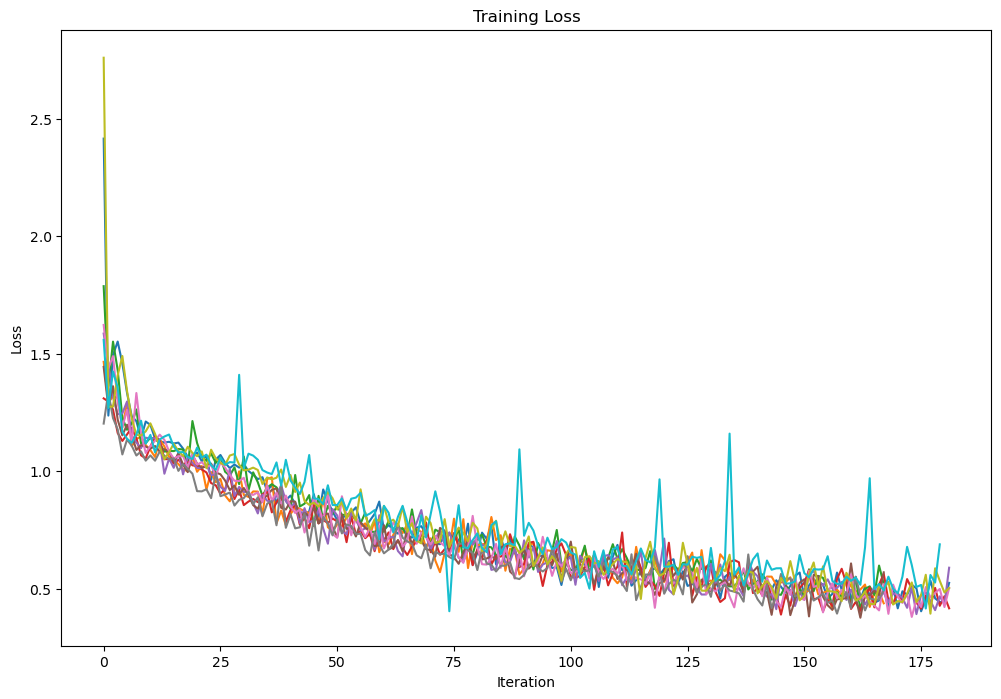

In [15]:
# losses
fig, axs = plt.subplots(figsize=(12, 8))
for i in range(len(all_losses)):
    axs.plot(all_losses[i])

axs.set_ylabel("Loss")
axs.set_xlabel("Iteration")
axs.set_title("Training Loss")
fig.savefig("gender_loss.png")
plt.show()

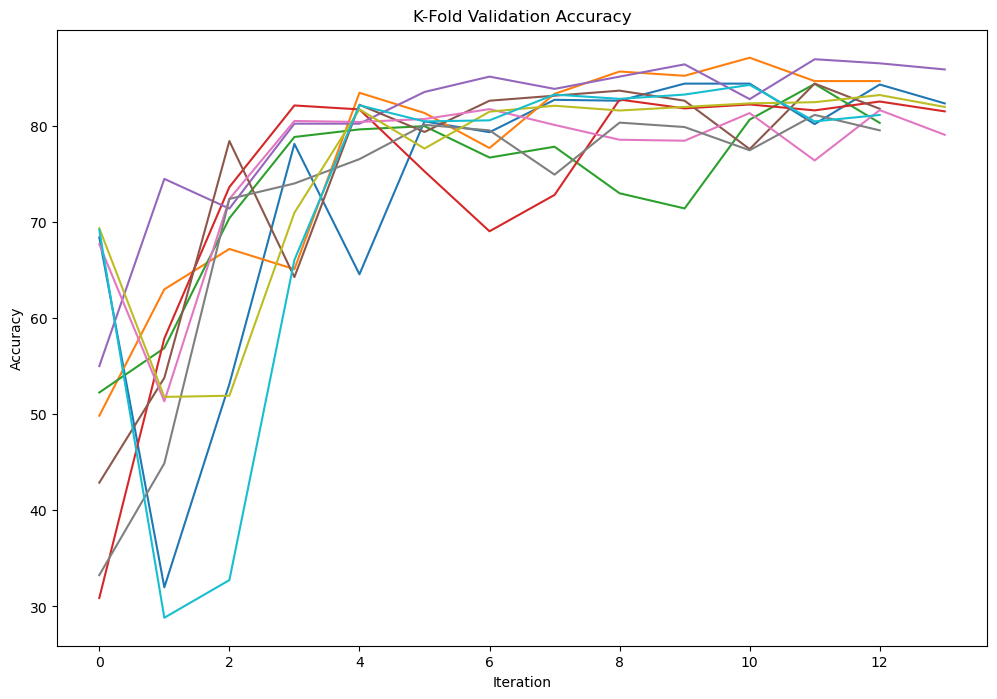

In [16]:
# losses
fig, axs = plt.subplots(figsize=(12, 8))
for i in range(len(all_accuracies)):
    axs.plot(all_accuracies[i])

axs.set_ylabel("Accuracy")
axs.set_xlabel("Iteration")
axs.set_title("K-Fold Validation Accuracy")
fig.savefig("gender_acc.png")
plt.show()

In [7]:
# saving the ensemble models
for i in range(len(final_models)):
    filepath = "saved_models/gender_classification/model"+str(i)+".pth"
    torch.save(final_models[i].state_dict(), filepath)

'\nfor i in range(len(final_models)):\n    filepath = "saved_models/gender_classification/model"+str(i)+".pth"\n    torch.save(final_models[i].state_dict(), filepath)\n'

In [121]:
# reload the ensemble models
num_layers = 4
num_classes = 2 # M/F
hidden_dim = 256
num_heads = 4

ensemble = []
for i in range(10):
    model = MovieNetwork(775, hidden_dim, num_heads, num_layers, num_classes)
    model.load_state_dict(torch.load("saved_models/gender_classification/model"+str(i)+".pth"))
    model = model.eval()
    ensemble.append(copy.deepcopy(model))

# load the dataset
dataset = MovieGalaxiesDataset("data/")
loader = DataLoader(dataset, batch_size=1, shuffle=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 776/776 [00:14<00:00, 54.40it/s]


In [122]:
def run_ensemble(ensemble, data):
    predictions = []
    for model in ensemble:
        model = model.to(device)
        with torch.no_grad():
            pred = model(data).argmax(dim=1)
            predictions.append(pred)
        
    return torch.stack(predictions).mean(dim=0, dtype=float)

# calculate predictions and accuracy
y_true = []
y_preds = []
gids = []
for batch in tqdm(loader, total=776):
    preds = run_ensemble(ensemble, batch)
    y_true.extend(batch.y.tolist())
    y_preds.extend(preds.tolist())
    gids.extend(batch.gid)
    
y_true = np.array(y_true)
y_preds = np.array(y_preds)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 776/776 [02:40<00:00,  4.84it/s]


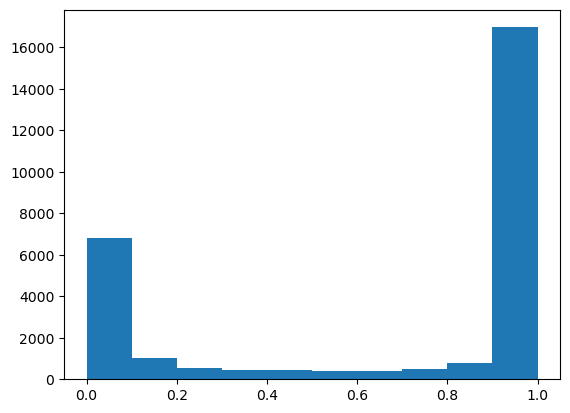

In [123]:
plt.hist(y_preds, bins=10)
plt.show()

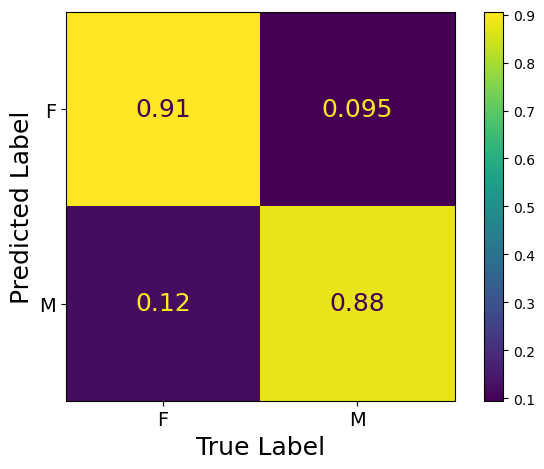

In [137]:
cm = confusion_matrix(y_true[y_true != -1], (y_preds > 0.5).astype(int)[y_true != -1], normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["F", "M"])
fig = disp.plot()

for labels in disp.text_.ravel():
    labels.set_fontsize(18)
    
[item.set_fontsize(14) for item in disp.ax_.get_xticklabels()]
[item.set_fontsize(14) for item in disp.ax_.get_yticklabels()]
disp.ax_.set_xlabel("True Label", fontsize=18)
disp.ax_.set_ylabel("Predicted Label", fontsize=18)

plt.tight_layout()
plt.savefig("gender_label_class_matrix.png")
plt.show()

In [65]:
for step, batch in tqdm(enumerate(loader), total=776):
    preds = run_ensemble(ensemble, batch)
    
    if step == 4:
        break

  1%|▋                                                                                                                                               | 4/776 [00:00<02:46,  4.64it/s]


In [23]:
# generate predictions for all nodes in MovieGalaxies and save to new folder

node_attrs = ["Eccentricity", "Closeness Centrality", "Betweenness Centrality", "Degree", "Component ID",
              "Modularity Class", "gender", "size", "name"]
edge_attrs = ["weight"]
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

for idx, batch in tqdm(enumerate(loader), total=776):
    preds = run_ensemble(ensemble, batch)
    gt_gender = np.array(batch.y)
    pred_gender = np.array(preds.tolist())
    
    genders = np.zeros((len(preds)))
    genders[gt_gender != -1] = gt_gender[gt_gender != -1]
    genders[gt_gender == -1] = pred_gender[gt_gender == -1]
    
    data = batch[0]
    gid = batch.gid[0]
    data.gender = genders
    data.name = [tokenizer.decode(x) for x in data.name]
    
    graph = to_networkx(data, node_attrs=node_attrs, edge_attrs=edge_attrs, to_undirected=True)
    
    filename = "data/MovieGalaxies/gender_labelled/graph"+str(gid)+".graphml"
    nx.write_graphml(graph, filename)

  0%|          | 0/776 [00:00<?, ?it/s]

## All Movies Gender Ratio Analysis

In [114]:
### Data Loading ###

root = "data/"

# I'm the only one going to be using these so I didn't bother making it generalizable
# load
metadata = pd.read_csv(root + "MoviesDataset/movies_metadata.csv")
links = pd.read_csv(root + "MoviesDataset/links.csv")
credits = pd.read_csv("data/MoviesDataset/credits.csv")

# cleaning
movie_data = pd.merge(credits, metadata, on='id', how='inner')
movie_data = movie_data[~pd.isnull(movie_data['imdb_id'])]
movie_data['imdb_id'] = movie_data['imdb_id'].apply(lambda x: x[2:])

# add info about cast 
movie_data['num_female'] = movie_data['cast'].apply(lambda x:
    len([y for y in ast.literal_eval(x) if y['gender'] == 1]))
movie_data['num_characters'] = movie_data['cast'].apply(lambda x: len(ast.literal_eval(x)))
movie_data['num_male'] = movie_data['num_characters'] - movie_data['num_female']
movie_data['female_ratio'] = movie_data['num_female'] / movie_data['num_characters']
movie_data['female_ratio'] = movie_data['female_ratio'].fillna(0)

# dummy columns for genres
all_genres = {}
for idx, row in movie_data.iterrows():
    genres = ast.literal_eval(row['genres'])
    for x in genres:
        if x['name'] not in all_genres:
            all_genres[x['name']] = 0
        all_genres[x['name']] += 1
        
for genre in all_genres.keys():
    movie_data[genre] = movie_data['genres'].apply(lambda x: int(any([y['name'] == genre for y in ast.literal_eval(x)])))

# additional cleaning
# log revenue and vote_count since they're skewed
movie_data['revenue'] = movie_data['revenue'] / 10000
movie_data['revenue'][movie_data['revenue'] == 0] = movie_data['revenue'].mean()
movie_data['revenue'] = np.log(movie_data['revenue'])

#movie_data['vote_count'] = movie_data['vote_count'] / 100
movie_data['vote_count'][movie_data['vote_count'] == 0] = movie_data['vote_count'].mean()
movie_data['vote_count'] = np.log(movie_data['vote_count'])

# Release Date 
movie_data['release_date'] = movie_data['release_date'].apply(lambda x: int(x[:4]) if isinstance(x, str) else x)
num_na_releasedate = movie_data['release_date'].isna().sum()
movie_data['release_date'] = movie_data['release_date'].fillna(movie_data['release_date'].mean())
earliest_movie_releasedate = movie_data['release_date'].min()
movie_data['release_date'] = movie_data['release_date'] - movie_data['release_date'].min()

# split release date into percentile groups
# helps get around the horrible left skew in release date
movie_data['YearAbove1978'] = np.array(movie_data['release_date'] > movie_data['release_date'].quantile(0.25)).astype(int)
movie_data['YearAbove2001'] = np.array(movie_data['release_date'] > movie_data['release_date'].quantile(0.5)).astype(int)
movie_data['YearAbove2010'] = np.array(movie_data['release_date'] > movie_data['release_date'].quantile(0.75)).astype(int)

feat_columns = [
    'runtime', 'vote_average', 'vote_count', 'Animation', 'Comedy', 'Family', 'Adventure',
    'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History',
    'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western',
    'TV Movie', 'YearAbove1978', 'YearAbove2001', 'YearAbove2010', 'release_date', 'num_female',
    'num_characters', 'female_ratio', 'num_male'
]

movie_data = movie_data[feat_columns].dropna()
[feat_columns.remove(x) for x in ['release_date', 'num_female', 'num_characters', 'num_male', 'female_ratio']]

# remove outlier
movie_data = movie_data[movie_data['num_male'] <= 250]
movie_data = movie_data.reset_index(drop=True)

C:\Users\shirl\AppData\Local\Temp\ipykernel_15044\1449913543.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['revenue'][movie_data['revenue'] == 0] = movie_data['revenue'].mean()
C:\Users\shirl\AppData\Local\Temp\ipykernel_15044\1449913543.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['vote_count'][movie_data['vote_count'] == 0] = movie_data['vote_count'].mean()


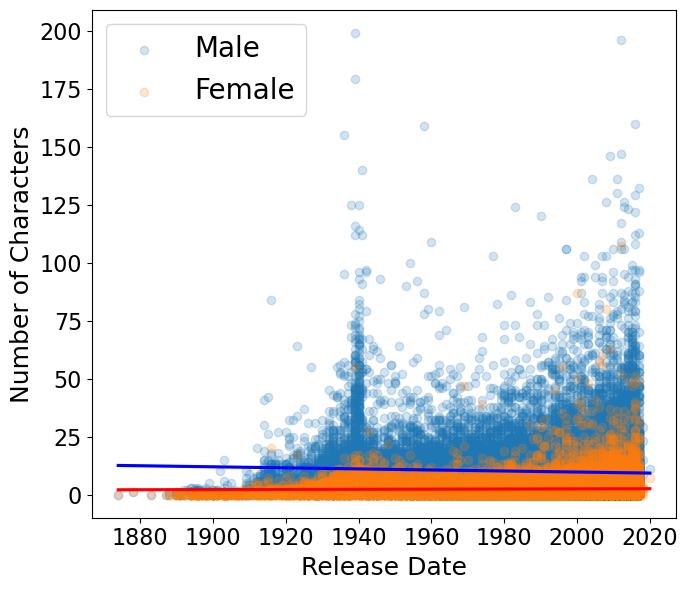

In [120]:
fig, axs = plt.subplots(figsize=(7, 6))

sns.regplot(x=movie_data['release_date'] + earliest_movie_releasedate, y=movie_data['num_male'], 
            line_kws={"color": 'blue'}, scatter_kws={'alpha': 0.2}, ax=axs, label="Male")
sns.regplot(x=movie_data['release_date'] + earliest_movie_releasedate, y=movie_data['num_female'], 
            line_kws={"color": 'red'}, scatter_kws={'alpha': 0.2}, ax=axs, label="Female")
axs.legend(prop={'size': 20})

[item.set_fontsize(16) for item in axs.get_xticklabels()]
[item.set_fontsize(16) for item in axs.get_yticklabels()]

axs.set_xlabel("Release Date", fontsize=18)
axs.set_ylabel("Number of Characters", fontsize=18)

plt.tight_layout()
fig.savefig("num_char1.png")

In [100]:
# release date predicting female ratio

ratio_model = sm.RLM(movie_data['female_ratio'], sm.add_constant(movie_data[['release_date']])).fit()
ratio_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:           female_ratio   No. Observations:                45263
Model:                            RLM   Df Residuals:                    45261
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 04 Dec 2022                                         
Time:                        21:57:51                                         
No. Iterations:                    24                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1677      0.004     44.094      0.000       0.160       0.175
release_date     0.0001   3.16e-05      3.649      0.000    5.34e-05       0.000
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [106]:
# release date predicting number of females

ratio_model = sm.RLM(movie_data['num_female'], sm.add_constant(movie_data[['release_date']])).fit()
ratio_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:             num_female   No. Observations:                45263
Model:                            RLM   Df Residuals:                    45261
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 04 Dec 2022                                         
Time:                        22:18:26                                         
No. Iterations:                    24                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.1714      0.043     50.513      0.000       2.087       2.256
release_date    -0.0020      0.000     -5.701      0.000      -0.003      -0.001
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [109]:
# release date predicting number of males

ratio_model = sm.RLM(movie_data['num_male'], sm.add_constant(movie_data[['release_date']])).fit()
ratio_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:               num_male   No. Observations:                45263
Model:                            RLM   Df Residuals:                    45261
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 04 Dec 2022                                         
Time:                        22:18:36                                         
No. Iterations:                    23                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           11.0818      0.141     78.583      0.000      10.805      11.358
release_date    -0.0239      0.001    -20.410      0.000      -0.026      -0.022
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [97]:
# release date predicting number of males

ratio_model = sm.RLM(movie_data['num_characters'], sm.add_constant(movie_data[['release_date']])).fit()
ratio_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:         num_characters   No. Observations:                45263
Model:                            RLM   Df Residuals:                    45261
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 04 Dec 2022                                         
Time:                        21:57:26                                         
No. Iterations:                    18                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           13.5929      0.176     77.067      0.000      13.247      13.939
release_date    -0.0260      0.001    -17.745      0.000      -0.029      -0.023
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

## Bechdel Rating Prediction

Using the subset of data with Bechdel ratings.

In [138]:
### Data Loading ###

root = "data/"

# I'm the only one going to be using these so I didn't bother making it generalizable
# load
metadata = pd.read_csv(root + "MoviesDataset/movies_metadata.csv")
links = pd.read_csv(root + "MoviesDataset/links.csv")
bechedel_data = pd.read_json(root + "bechedeltest.json", orient='records')
credits = pd.read_csv("data/MoviesDataset/credits.csv")

# cleaning
movie_data = pd.merge(credits, metadata, on='id', how='inner')
movie_data = movie_data[~pd.isnull(movie_data['imdb_id'])]
movie_data['imdb_id'] = movie_data['imdb_id'].apply(lambda x: x[2:])

# add info about cast 
movie_data['num_female'] = movie_data['cast'].apply(lambda x:
    len([y for y in ast.literal_eval(x) if y['gender'] == 1]))
movie_data['num_characters'] = movie_data['cast'].apply(lambda x: len(ast.literal_eval(x)))
movie_data['female_ratio'] = movie_data['num_female'] / movie_data['num_characters']
movie_data['female_ratio'] = movie_data['female_ratio'].fillna(0)

# add bechedel data info
movie_data = pd.merge(movie_data, bechedel_data, left_on='imdb_id', right_on='imdbid', how='inner')

save_columns = [
    'genres', 'overview', 'popularity', 'release_date', 'revenue', 'runtime', 'vote_average',
    'vote_count', 'rating', 'num_female', 'female_ratio', 'title_x'
]
movie_data = movie_data[save_columns]

# dummy columns for genres
all_genres = {}
for idx, row in movie_data.iterrows():
    genres = ast.literal_eval(row['genres'])
    for x in genres:
        if x['name'] not in all_genres:
            all_genres[x['name']] = 0
        all_genres[x['name']] += 1
        
for genre in all_genres.keys():
    movie_data[genre] = movie_data['genres'].apply(lambda x: int(any([y['name'] == genre for y in ast.literal_eval(x)])))

# additional cleaning
# log revenue and vote_count since they're skewed
movie_data['revenue'] = movie_data['revenue'] / 10000
movie_data['revenue'][movie_data['revenue'] == 0] = movie_data['revenue'].mean()
movie_data['revenue'] = np.log(movie_data['revenue'])

movie_data['vote_count'][movie_data['vote_count'] == 0] = movie_data['vote_count'].mean()
movie_data['vote_count'] = np.log(movie_data['vote_count'])

# Release Date 
movie_data['release_date'] = movie_data['release_date'].apply(lambda x: int(x[:4]) if isinstance(x, str) else x)
num_na_releasedate = movie_data['release_date'].isna().sum()
movie_data['release_date'] = movie_data['release_date'].fillna(movie_data['release_date'].mean())
earliest_movie_releasedate = movie_data['release_date'].min()
movie_data['release_date'] = movie_data['release_date'] - movie_data['release_date'].min()

# split release date into percentile groups
# helps get around the horrible left skew in release date
movie_data['YearAbove1978'] = np.array(movie_data['release_date'] > 1978 - earliest_movie_releasedate).astype(int)
movie_data['YearAbove2001'] = np.array(movie_data['release_date'] > 2001 - earliest_movie_releasedate).astype(int)
movie_data['YearAbove2010'] = np.array(movie_data['release_date'] > 2010 - earliest_movie_releasedate).astype(int)

feat_columns = list(movie_data.columns)
feat_columns.remove('genres')
feat_columns.remove('overview')
feat_columns.remove('title_x')
feat_columns.remove('rating')
feat_columns.remove('release_date')
feat_columns.remove('popularity')

# labels
above0 = torch.from_numpy((movie_data['rating'] > 0).to_numpy()).int()
above1 = torch.from_numpy((movie_data['rating'] > 1).to_numpy()).int()
above2 = torch.from_numpy((movie_data['rating'] > 2).to_numpy()).int()
bechdel_labels = torch.vstack([above0, above1, above2]).T
bechdel_labels = bechdel_labels.float()
ratings = movie_data['rating'].to_numpy()

pd_bechdel_labels = pd.DataFrame(bechdel_labels, columns=["P>0", "P>1", "P>2"])

C:\Users\shirl\AppData\Local\Temp\ipykernel_15044\3483466364.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['revenue'][movie_data['revenue'] == 0] = movie_data['revenue'].mean()
C:\Users\shirl\AppData\Local\Temp\ipykernel_15044\3483466364.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['vote_count'][movie_data['vote_count'] == 0] = movie_data['vote_count'].mean()


In [140]:
def model_accuracy(model1, model2, model3, testdata, gt_labels):
    """
    Statsmodels makes me do one model per output
    """
    pred1 = (model1.predict(testdata) > 0.5).to_numpy().astype(int)
    pred2 = (model2.predict(testdata) > 0.5).to_numpy().astype(int)
    pred3 = (model3.predict(testdata) > 0.5).to_numpy().astype(int)
    
    # only go to the next level if it meets the previous level
    preds = pred1 
    preds[preds == 1] = preds[preds == 1] + pred2[preds == 1]
    preds[preds == 2] = preds[preds == 2] + pred3[preds == 2]
    #preds = pred1 + pred2 + pred3
    
    accuracy = (preds == gt_labels).astype(int).sum() / len(gt_labels)
    return accuracy, preds

In [171]:
log_reg1 = sm.Logit(pd_bechdel_labels['P>0'], sm.add_constant(movie_data[feat_columns])).fit()
log_reg2 = sm.Logit(pd_bechdel_labels[pd_bechdel_labels['P>0'] == 1]['P>1'], 
                    sm.add_constant(movie_data[movie_data['rating'] > 0][feat_columns])).fit()
log_reg3 = sm.Logit(pd_bechdel_labels[pd_bechdel_labels['P>1'] == 1]['P>2'], 
                    sm.add_constant(movie_data[movie_data['rating'] > 1][feat_columns])).fit()

acc, preds = model_accuracy(log_reg1, log_reg2, log_reg3, sm.add_constant(movie_data[feat_columns]), ratings)
acc

Optimization terminated successfully.
         Current function value: 0.247884
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.505026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411917
         Iterations 8


0.5941465941465941

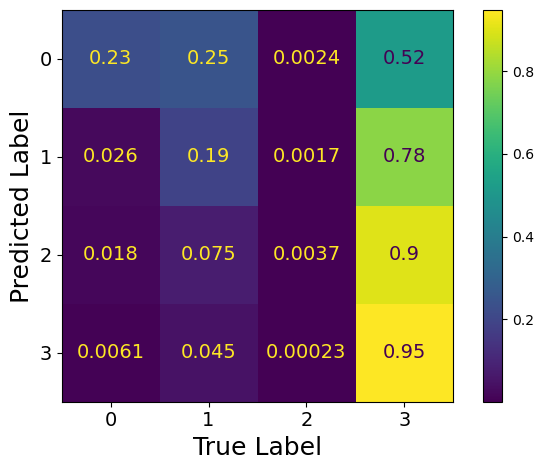

In [149]:
disp = ConfusionMatrixDisplay.from_predictions(
    ratings, preds, labels=[0, 1, 2, 3], normalize='true'
)

for labels in disp.text_.ravel():
    labels.set_fontsize(14)
    
[item.set_fontsize(14) for item in disp.ax_.get_xticklabels()]
[item.set_fontsize(14) for item in disp.ax_.get_yticklabels()]
disp.ax_.set_xlabel("True Label", fontsize=18)
disp.ax_.set_ylabel("Predicted Label", fontsize=18)

plt.tight_layout()
plt.savefig("part2_classmatrix.png")
plt.show()

In [150]:
def get_info_from_summary(info_table):
    sig_coefs = {}
    sig_intervals = {}
    unsig_coefs = {}
    unsig_intervals = {}
    for i in range(1, len(info_table)):
        if float(info_table[i][4]) < 0.05:
            sig_coefs[info_table[i][0]] = float(info_table[i][1])
            sig_intervals[info_table[i][0]] = (float(info_table[i][5]), float(info_table[i][6]))
        else:
            unsig_coefs[info_table[i][0]] = float(info_table[i][1])
            unsig_intervals[info_table[i][0]] = (float(info_table[i][5]), float(info_table[i][6]))
            
    return sig_coefs, sig_intervals, unsig_coefs, unsig_intervals

sig_coefs1, sig_intervals1, unsig_coefs1, unsig_intervals1 = get_info_from_summary(log_reg1.summary().tables[1].data)
sig_coefs2, sig_intervals2, unsig_coefs2, unsig_intervals2 = get_info_from_summary(log_reg2.summary().tables[1].data)
sig_coefs3, sig_intervals3, unsig_coefs3, unsig_intervals3 = get_info_from_summary(log_reg3.summary().tables[1].data)

In [173]:
genres_key = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 
              'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 
              'Romance', 'Science Fiction', 'Thriller', 'TV Movie', 'War', 'Western'
             ]
years_key = ['YearAbove1978', 'YearAbove2001', 'YearAbove2010']
others_key = ['runtime', 'vote_average', 'vote_count', 'revenue',  'num_female']

genres_key = {genres_key[i]: len(genres_key)-i for i in range(len(genres_key))}
years_key = {years_key[i]: len(years_key)-i for i in range(len(years_key))}
others_key = {others_key[i]: len(others_key)-i for i in range(len(others_key))}

In [231]:
def coefplot(coefs, intervals, labeldata, ax, label, bold=True, color='blue'):
    if bold:
        capsize=5
        lw=3
        s=40
    else:
        capsize=4
        lw=1
        s=20
    
    widths = (np.array(list(intervals.values())).T - np.array(list(coefs.values())))
    widths[0] = widths[0] * -1
    
    ax.errorbar(list(coefs.values()), labeldata, capsize=capsize,
                xerr=widths, linewidth=0, elinewidth=lw, label=label, color=color)

    ax.axvline(x=0, c='red', linestyle='--')
    ax.scatter(y=labeldata, marker='o', s=s, x=list(coefs.values()), color=color)
    
def subset_plotdata(coefs_dict, intervals_dict, plottype='genre'):
    if plottype == 'genre':
        use_key = genres_key
    elif plottype == 'year':
        use_key = years_key
    elif plottype == 'connection':
        use_key = connections_key
    else:
        use_key = others_key
        
    labels = [use_key[x] for x in coefs_dict if x in use_key]
    coefs = {k : v for k, v in coefs_dict.items() if k in use_key}
    intervals = {k : v for k, v in intervals_dict.items() if k in use_key}
    
    return labels, coefs, intervals

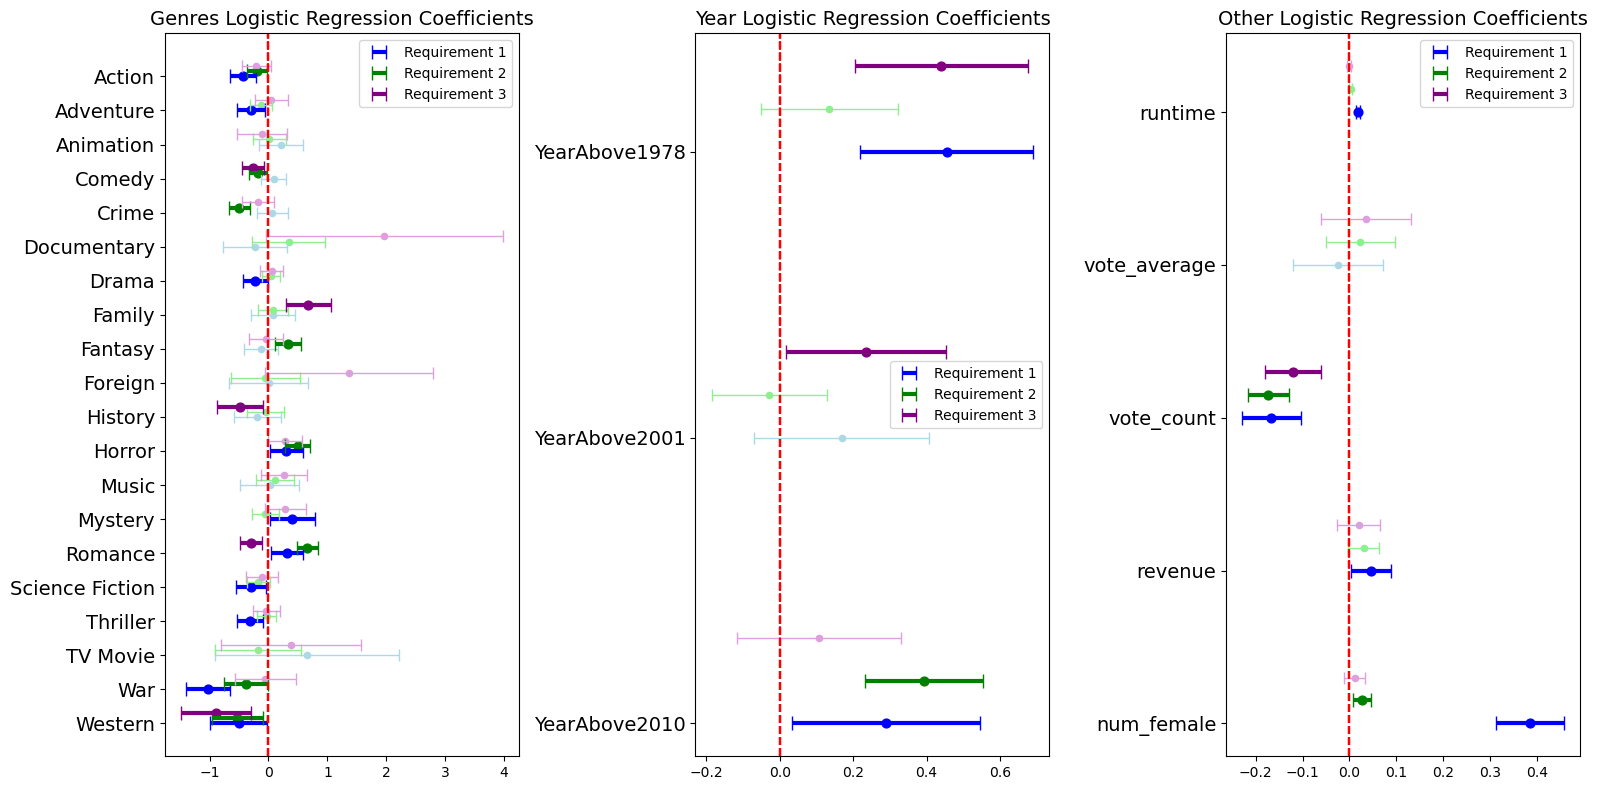

In [181]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

### Genres ###
labels, coefs, intervals = subset_plotdata(unsig_coefs1, unsig_intervals1, plottype='genre')
coefplot(coefs, intervals, labels, axs[0], None, bold=False, color='lightblue')

labels, coefs, intervals = subset_plotdata(sig_coefs1, sig_intervals1, plottype='genre')
coefplot(coefs, intervals, labels, axs[0], "Requirement 1", bold=True, color='blue')

labels, coefs, intervals = subset_plotdata(unsig_coefs2, unsig_intervals2, plottype='genre')
labels = np.array(labels) + 0.15
coefplot(coefs, intervals, labels, axs[0], None, bold=False, color='lightgreen')

labels, coefs, intervals = subset_plotdata(sig_coefs2, sig_intervals2, plottype='genre')
labels = np.array(labels) + 0.15
coefplot(coefs, intervals, labels, axs[0], "Requirement 2", bold=True, color='green')

labels, coefs, intervals = subset_plotdata(unsig_coefs3, unsig_intervals3, plottype='genre')
labels = np.array(labels) + 0.3
coefplot(coefs, intervals, labels, axs[0], None, bold=False, color='plum')

labels, coefs, intervals = subset_plotdata(sig_coefs3, sig_intervals3, plottype='genre')
labels = np.array(labels) + 0.3
coefplot(coefs, intervals, labels, axs[0], "Requirement 3", bold=True, color='purple')

axs[0].set_yticks(list(genres_key.values()))
axs[0].set_yticklabels(list(genres_key.keys()), fontsize=14)
axs[0].legend()
axs[0].set_title("Genres Logistic Regression Coefficients", fontsize=14)

### Time ###
labels, coefs, intervals = subset_plotdata(unsig_coefs1, unsig_intervals1, plottype='year')
coefplot(coefs, intervals, labels, axs[1], None, bold=False, color='lightblue')

labels, coefs, intervals = subset_plotdata(sig_coefs1, sig_intervals1, plottype='year')
coefplot(coefs, intervals, labels, axs[1], "Requirement 1", bold=True, color='blue')

labels, coefs, intervals = subset_plotdata(unsig_coefs2, unsig_intervals2, plottype='year')
labels = np.array(labels) + 0.15
coefplot(coefs, intervals, labels, axs[1], None, bold=False, color='lightgreen')

labels, coefs, intervals = subset_plotdata(sig_coefs2, sig_intervals2, plottype='year')
labels = np.array(labels) + 0.15
coefplot(coefs, intervals, labels, axs[1], "Requirement 2", bold=True, color='green')

labels, coefs, intervals = subset_plotdata(unsig_coefs3, unsig_intervals3, plottype='year')
labels = np.array(labels) + 0.3
coefplot(coefs, intervals, labels, axs[1], None, bold=False, color='plum')

labels, coefs, intervals = subset_plotdata(sig_coefs3, sig_intervals3, plottype='year')
labels = np.array(labels) + 0.3
coefplot(coefs, intervals, labels, axs[1], "Requirement 3", bold=True, color='purple')

axs[1].set_yticks(list(years_key.values()))
axs[1].set_yticklabels(list(years_key.keys()), fontsize=14)
axs[1].legend()
axs[1].set_title("Year Logistic Regression Coefficients", fontsize=14)

### other ###
labels, coefs, intervals = subset_plotdata(unsig_coefs1, unsig_intervals1, plottype='other')
coefplot(coefs, intervals, labels, axs[2], None, bold=False, color='lightblue')

labels, coefs, intervals = subset_plotdata(sig_coefs1, sig_intervals1, plottype='other')
coefplot(coefs, intervals, labels, axs[2], "Requirement 1", bold=True, color='blue')

labels, coefs, intervals = subset_plotdata(unsig_coefs2, unsig_intervals2, plottype='other')
labels = np.array(labels) + 0.15
coefplot(coefs, intervals, labels, axs[2], None, bold=False, color='lightgreen')

labels, coefs, intervals = subset_plotdata(sig_coefs2, sig_intervals2, plottype='other')
labels = np.array(labels) + 0.15
coefplot(coefs, intervals, labels, axs[2], "Requirement 2", bold=True, color='green')

labels, coefs, intervals = subset_plotdata(unsig_coefs3, unsig_intervals3, plottype='other')
labels = np.array(labels) + 0.3
coefplot(coefs, intervals, labels, axs[2], None, bold=False, color='plum')

labels, coefs, intervals = subset_plotdata(sig_coefs3, sig_intervals3, plottype='other')
labels = np.array(labels) + 0.3
coefplot(coefs, intervals, labels, axs[2], "Requirement 3", bold=True, color='purple')

axs[2].set_yticks(list(others_key.values()))
axs[2].set_yticklabels(list(others_key.keys()), fontsize=14)
axs[2].legend()
axs[2].set_title("Other Logistic Regression Coefficients", fontsize=14)


plt.tight_layout()
fig.savefig("coefficients.png")
plt.show()

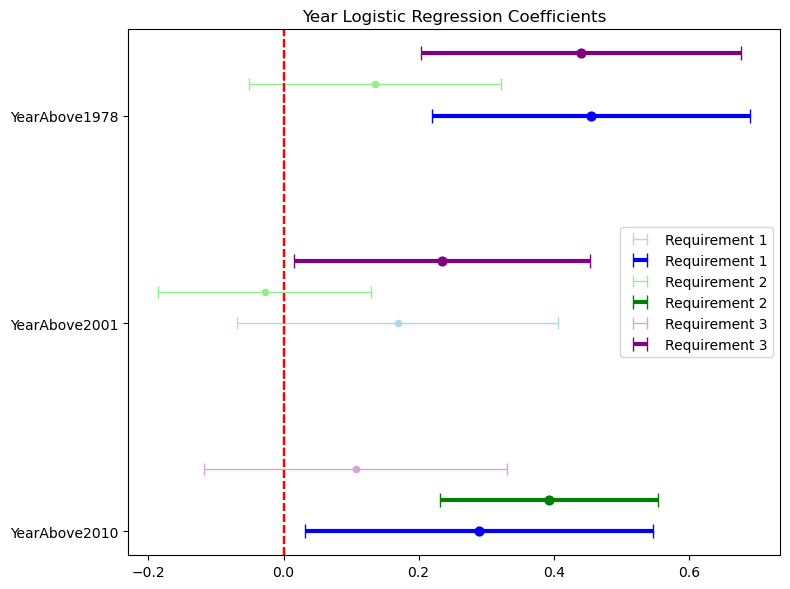

In [154]:
fig, axs = plt.subplots(figsize=(8, 6))

labels, coefs, intervals = subset_plotdata(unsig_coefs1, unsig_intervals1, plottype='year')
coefplot(coefs, intervals, labels, axs, "Requirement 1", bold=False, color='lightblue')

labels, coefs, intervals = subset_plotdata(sig_coefs1, sig_intervals1, plottype='year')
coefplot(coefs, intervals, labels, axs, "Requirement 1", bold=True, color='blue')

labels, coefs, intervals = subset_plotdata(unsig_coefs2, unsig_intervals2, plottype='year')
labels = np.array(labels) + 0.15
coefplot(coefs, intervals, labels, axs, "Requirement 2", bold=False, color='lightgreen')

labels, coefs, intervals = subset_plotdata(sig_coefs2, sig_intervals2, plottype='year')
labels = np.array(labels) + 0.15
coefplot(coefs, intervals, labels, axs, "Requirement 2", bold=True, color='green')

labels, coefs, intervals = subset_plotdata(unsig_coefs3, unsig_intervals3, plottype='year')
labels = np.array(labels) + 0.3
coefplot(coefs, intervals, labels, axs, "Requirement 3", bold=False, color='plum')

labels, coefs, intervals = subset_plotdata(sig_coefs3, sig_intervals3, plottype='year')
labels = np.array(labels) + 0.3
coefplot(coefs, intervals, labels, axs, "Requirement 3", bold=True, color='purple')

axs.set_yticks(list(years_key.values()))
axs.set_yticklabels(list(years_key.keys()))
axs.legend()

axs.set_title("Year Logistic Regression Coefficients")
plt.tight_layout()
fig.savefig("year_coefs.png")
plt.show()

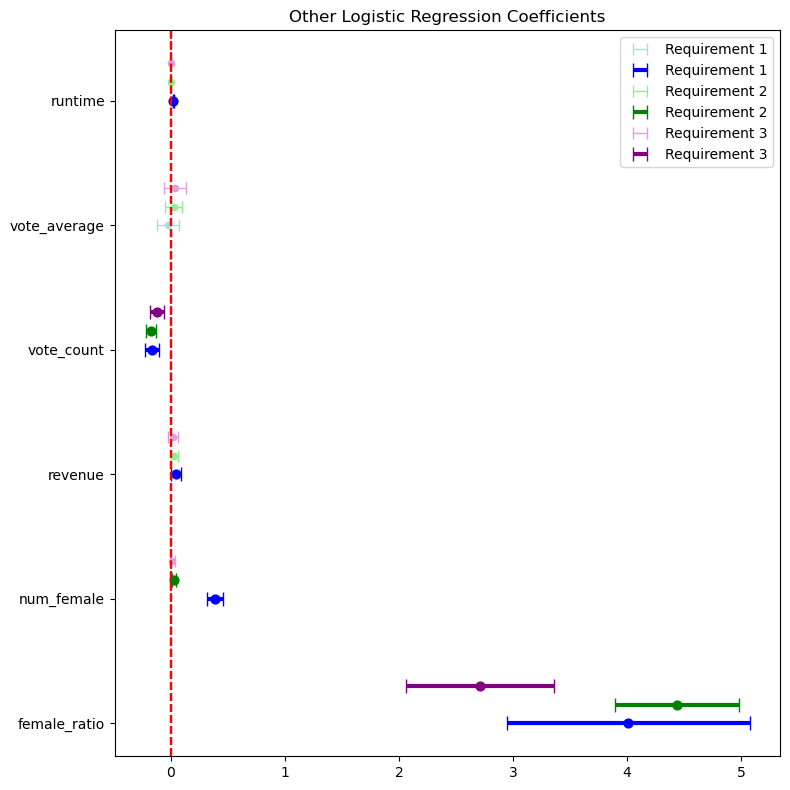

In [158]:
fig, axs = plt.subplots(figsize=(8, 8))

labels, coefs, intervals = subset_plotdata(unsig_coefs1, unsig_intervals1, plottype='other')
coefplot(coefs, intervals, labels, axs, "Requirement 1", bold=False, color='lightblue')

labels, coefs, intervals = subset_plotdata(sig_coefs1, sig_intervals1, plottype='other')
coefplot(coefs, intervals, labels, axs, "Requirement 1", bold=True, color='blue')

labels, coefs, intervals = subset_plotdata(unsig_coefs2, unsig_intervals2, plottype='other')
labels = np.array(labels) + 0.15
coefplot(coefs, intervals, labels, axs, "Requirement 2", bold=False, color='lightgreen')

labels, coefs, intervals = subset_plotdata(sig_coefs2, sig_intervals2, plottype='other')
labels = np.array(labels) + 0.15
coefplot(coefs, intervals, labels, axs, "Requirement 2", bold=True, color='green')

labels, coefs, intervals = subset_plotdata(unsig_coefs3, unsig_intervals3, plottype='other')
labels = np.array(labels) + 0.3
coefplot(coefs, intervals, labels, axs, "Requirement 3", bold=False, color='plum')

labels, coefs, intervals = subset_plotdata(sig_coefs3, sig_intervals3, plottype='other')
labels = np.array(labels) + 0.3
coefplot(coefs, intervals, labels, axs, "Requirement 3", bold=True, color='purple')

axs.set_yticks(list(others_key.values()))
axs.set_yticklabels(list(others_key.keys()))
axs.legend()

axs.set_title("Other Logistic Regression Coefficients")
plt.tight_layout()
fig.savefig("other_coefs.png")
plt.show()

## MovieGalaxies Graph Analysis

Removed GAT code from here.

Aggregation of node and edge-level features into movie level ones, and then doing logistic regression on movies to predict Bechdel Level

In [182]:
def add_connection_info(graph):
    num_characters = len(graph.nodes)
    num_female = 0
    num_male = 0

    for n in graph.nodes:
        if graph.nodes[n]['gender'] < 0.5:
            num_female += 1
        else:
            num_male += 1

    num_ff_connections = 0
    num_fm_connections = 0
    num_mm_connections = 0
    weighted_ff_connections = 0
    weighted_fm_connections = 0
    weighted_mm_connections = 0
    max_ff_connection = 0
    max_fm_connection = 0
    max_mm_connection = 0

    for e in graph.edges:
        char1 = e[0]
        char2 = e[1]
        if (graph.nodes[char1]['gender'] < 0.5) and (graph.nodes[char2]['gender'] < 0.5):
            num_ff_connections += 1
            weighted_ff_connections += graph.edges[e]['weight']
            if graph.edges[e]['weight'] > max_ff_connection:
                max_ff_connection = graph.edges[e]['weight']
        elif (graph.nodes[char1]['gender'] >= 0.5) and (graph.nodes[char2]['gender'] >= 0.5):
            num_mm_connections += 1
            weighted_mm_connections += graph.edges[e]['weight']
            if graph.edges[e]['weight'] > max_mm_connection:
                max_mm_connection = graph.edges[e]['weight']
        else:
            num_fm_connections += 1
            weighted_fm_connections += graph.edges[e]['weight']
            if graph.edges[e]['weight'] > max_fm_connection:
                max_fm_connection = graph.edges[e]['weight']

    graph.graph['num_ff_connections'] = num_ff_connections
    graph.graph['num_fm_connections'] = num_fm_connections
    graph.graph['num_mm_connections'] = num_mm_connections
    #graph.graph['weighted_ff_connections'] = weighted_ff_connections
    #graph.graph['weighted_fm_connections'] = weighted_fm_connections
    #graph.graph['weighted_mm_connections'] = weighted_mm_connections
    graph.graph['max_ff_connection'] = max_ff_connection
    graph.graph['max_fm_connection'] = max_fm_connection
    graph.graph['max_mm_connection'] = max_mm_connection
    graph.graph['num_female'] = num_female
    graph.graph['num_male'] = num_male

    return graph


In [185]:
root = "data/"

metadata = pd.read_csv(root + "MoviesDataset/movies_metadata.csv")
links = pd.read_csv(root + "MoviesDataset/links.csv")
bechedel_data = pd.read_json(root + "bechedeltest.json", orient='records')
credits = pd.read_csv("data/MoviesDataset/credits.csv")
galaxies_metadata = pd.read_table("data/MovieGalaxies/network_metadata.tab")

# cleaning
movie_data = pd.merge(credits, metadata, on='id', how='inner')
movie_data = movie_data[~pd.isnull(movie_data['imdb_id'])]
movie_data['imdb_id'] = movie_data['imdb_id'].apply(lambda x: x[2:])
galaxies_metadata['IMDB_id'] = galaxies_metadata['IMDB_id'].apply(lambda x: x[2:])
movie_data = pd.merge(galaxies_metadata, movie_data, how='inner', left_on='IMDB_id', right_on='imdb_id')

# add bechedel data info
movie_data = pd.merge(movie_data, bechedel_data, left_on='imdb_id', right_on='imdbid', how='inner')

save_columns = [
    'genres', 'overview', 'popularity', 'release_date', 'revenue', 'runtime', 'vote_average',
    'vote_count', 'rating', 'title_x'
]
#movie_data = movie_data[save_columns]

# dummy columns for genres
all_genres = {}
for idx, row in movie_data.iterrows():
    genres = ast.literal_eval(row['genres'])
    for x in genres:
        if x['name'] not in all_genres:
            all_genres[x['name']] = 0
        all_genres[x['name']] += 1
        
for genre in all_genres.keys():
    movie_data[genre] = movie_data['genres'].apply(lambda x: int(any([y['name'] == genre for y in ast.literal_eval(x)])))

# additional cleaning
# log revenue and vote_count since they're skewed
movie_data['revenue'] = movie_data['revenue'] / 10000
movie_data['revenue'][movie_data['revenue'] == 0] = movie_data['revenue'].mean()
movie_data['revenue'] = np.log(movie_data['revenue'])

movie_data['vote_count'][movie_data['vote_count'] == 0] = movie_data['vote_count'].mean()
movie_data['vote_count'] = np.log(movie_data['vote_count'])

# Release Date 
movie_data['release_date'] = movie_data['release_date'].apply(lambda x: int(x[:4]) if isinstance(x, str) else x)
num_na_releasedate = movie_data['release_date'].isna().sum()
movie_data['release_date'] = movie_data['release_date'].fillna(movie_data['release_date'].mean())
earliest_movie_releasedate = movie_data['release_date'].min()
movie_data['release_date'] = movie_data['release_date'] - movie_data['release_date'].min()

# split release date into percentile groups
# helps get around the horrible left skew in release date
movie_data['YearAbove1978'] = np.array(movie_data['release_date'] > 1978 - earliest_movie_releasedate).astype(int)
movie_data['YearAbove2001'] = np.array(movie_data['release_date'] > 2001 - earliest_movie_releasedate).astype(int)
#movie_data['year>=p0.75'] = np.array(movie_data['release_date'] > 2010 - earliest_movie_releasedate).astype(int)

# get graph features from node and edge connections
graph_info = defaultdict(list)
for gid in tqdm(range(len(movie_data))):
    filename = root + "MovieGalaxies/gender_labelled/graph" + str(movie_data.iloc[gid]['GexfID']) + ".graphml"
    graph = nx.read_graphml(filename)
    graph = add_connection_info(graph)
    graph.graph.pop('node_default')
    graph.graph.pop('edge_default')
    
    for key, value in graph.graph.items():
        graph_info[key].append(value)

movie_data = pd.concat([movie_data, pd.DataFrame(graph_info)], axis=1)
movie_data['female_ratio'] = movie_data['num_female'] / (movie_data['num_female'] + movie_data['num_male'])

# removed release_date for its indicator variables
# removed Western since too little instances and its also all rating > 0
feat_columns = [
    'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'Comedy', 'Romance', 
    'Drama', 'Adventure', 'Thriller', 'Science Fiction', 'Mystery', 'Action', 'Crime', 'Horror', 'Fantasy',
    'Music', 'History', 'Animation', 'Family', 'War', 'YearAbove1978', 'Western',
    'YearAbove2001', 'num_ff_connections', 'num_fm_connections', 'num_mm_connections', 
    #'weighted_ff_connections', 'weighted_fm_connections', 'weighted_mm_connections', 
    'max_ff_connection', 'max_fm_connection', 'max_mm_connection', 'female_ratio' #'release_date'
]

# manually removing outliers
# this removes Newsies and The Transformers: The Movie
movie_data = movie_data[movie_data['num_mm_connections'] < 400]

# this removes Thelma & Louise
movie_data = movie_data[movie_data['max_ff_connection'] < 30]

movie_data = movie_data.reset_index(drop=True)

# labels
above0 = torch.from_numpy((movie_data['rating'] > 0).to_numpy()).int()
above1 = torch.from_numpy((movie_data['rating'] > 1).to_numpy()).int()
above2 = torch.from_numpy((movie_data['rating'] > 2).to_numpy()).int()
bechdel_labels = torch.vstack([above0, above1, above2]).T
bechdel_labels = bechdel_labels.float()
ratings = movie_data['rating'].to_numpy()

pd_bechdel_labels = pd.DataFrame(bechdel_labels, columns=["P>0", "P>1", "P>2"])

C:\Users\shirl\AppData\Local\Temp\ipykernel_15044\1522672344.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['revenue'][movie_data['revenue'] == 0] = movie_data['revenue'].mean()
C:\Users\shirl\AppData\Local\Temp\ipykernel_15044\1522672344.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['vote_count'][movie_data['vote_count'] == 0] = movie_data['vote_count'].mean()
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 596/596 [00:01<00:00, 318.52it/s]


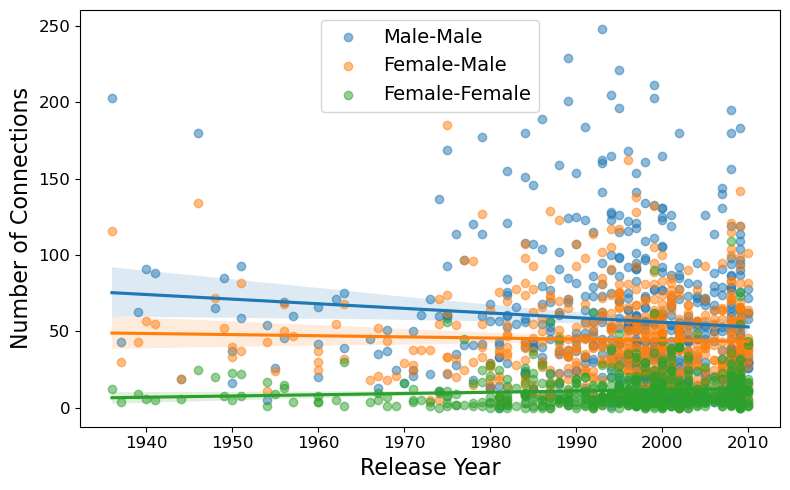

In [220]:
fig, axs = plt.subplots(figsize=(8, 5))

sns.regplot(x=movie_data['release_date'] + earliest_movie_releasedate, y=movie_data['num_mm_connections'], ax=axs, 
            label="Male-Male", scatter_kws={"alpha": 0.5})
sns.regplot(x=movie_data['release_date'] + earliest_movie_releasedate, y=movie_data['num_fm_connections'], ax=axs, 
            label="Female-Male", scatter_kws={"alpha": 0.5})
sns.regplot(x=movie_data['release_date'] + earliest_movie_releasedate, y=movie_data['num_ff_connections'], ax=axs, 
            label="Female-Female", scatter_kws={"alpha": 0.5})

axs.legend(prop={'size': 14})
axs.set_xlabel("Release Year", fontsize=16)
axs.set_ylabel("Number of Connections", fontsize=16)

[item.set_fontsize(12) for item in axs.get_xticklabels()]
[item.set_fontsize(12) for item in axs.get_yticklabels()]

plt.tight_layout()
plt.savefig("connections.png")
plt.show()

<AxesSubplot:xlabel='release_date', ylabel='max_ff_connection'>

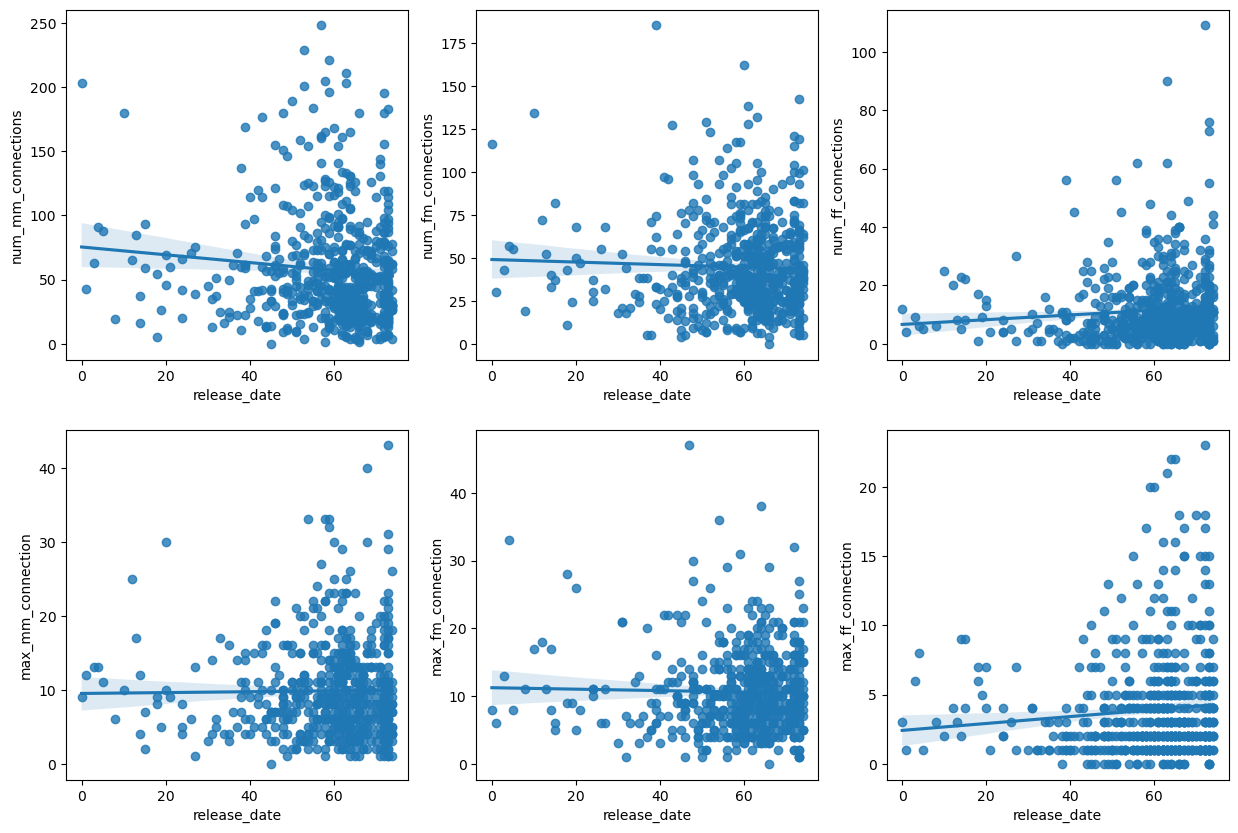

In [187]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# robust=True to ignore outliers 
sns.regplot(movie_data, x='release_date', y='num_mm_connections', ax=axs[0, 0])
sns.regplot(movie_data, x='release_date', y='num_fm_connections', ax=axs[0, 1])
sns.regplot(movie_data, x='release_date', y='num_ff_connections', ax=axs[0, 2])
sns.regplot(movie_data, x='release_date', y='max_mm_connection', ax=axs[1, 0])
sns.regplot(movie_data, x='release_date', y='max_fm_connection', ax=axs[1, 1])
sns.regplot(movie_data, x='release_date', y='max_ff_connection', ax=axs[1, 2])

In [199]:
num_mm_model = sm.RLM(movie_data['num_mm_connections'], 
                      sm.add_constant(movie_data[['YearAbove1978', 'YearAbove2001']])).fit()
num_fm_model = sm.RLM(movie_data['num_fm_connections'], 
                      sm.add_constant(movie_data[['YearAbove1978', 'YearAbove2001']])).fit()
num_ff_model = sm.RLM(movie_data['num_ff_connections'], 
                      sm.add_constant(movie_data[['YearAbove1978', 'YearAbove2001']])).fit()

max_mm_model = sm.RLM(movie_data['max_mm_connection'], 
                      sm.add_constant(movie_data[['YearAbove1978', 'YearAbove2001']])).fit()
max_fm_model = sm.RLM(movie_data['max_fm_connection'], 
                      sm.add_constant(movie_data[['YearAbove1978', 'YearAbove2001']])).fit()
max_ff_model = sm.RLM(movie_data['max_ff_connection'], 
                      sm.add_constant(movie_data[['YearAbove1978', 'YearAbove2001']])).fit()

In [221]:
num_mm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:     num_mm_connections   No. Observations:                  593
Model:                            RLM   Df Residuals:                      590
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 05 Dec 2022                                         
Time:                        02:21:49                                         
No. Iterations:                    15                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            53.2420      4.628     11.505      0.000      44.172      62.312
YearAbove1978     0.7284      4.992      0.146      0.884      -9.056      10.513
YearAbove2001    -7.7755      3.056     -2.545      0.011     -13.764      -1.787
=================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [194]:
max_mm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      max_mm_connection   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.015
Date:                Mon, 05 Dec 2022   Prob (F-statistic):              0.363
Time:                        02:04:58   Log-Likelihood:                -1931.3
No. Observations:                 593   AIC:                             3869.
Df Residuals:                     590   BIC:                             3882.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             9.1818      0.849     10.810      0.000       7.514      10.850
YearAbove1978     0.9670      0.916      1.055      0.292      -0.832       2.766
YearAbove2001    -0.6587      0.561     -1.175      0.241      -1.760       0.443
==============================================================================
Omnibus:                      164.225   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              422.165
Skew:                           1.396   Prob(JB):                     2.13e-92
Kurtosis:                       6.048   Cond. No.                         6.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [222]:
# it's actually hard for logistic regression to fit this, ncg is one of the only methods that will converge
log_reg1 = sm.Logit(pd_bechdel_labels['P>0'], sm.add_constant(movie_data[feat_columns])).fit(method='ncg', maxiter=100)
log_reg2 = sm.Logit(pd_bechdel_labels[pd_bechdel_labels['P>0'] == 1]['P>1'], 
                    sm.add_constant(movie_data[movie_data['rating'] > 0][feat_columns])).fit(method='ncg', maxiter=100)
log_reg3 = sm.Logit(pd_bechdel_labels[pd_bechdel_labels['P>1'] == 1]['P>2'], 
                    sm.add_constant(movie_data[movie_data['rating'] > 1][feat_columns])).fit(method='ncg', maxiter=100)

acc, preds = model_accuracy(log_reg1, log_reg2, log_reg3, sm.add_constant(movie_data[feat_columns]), ratings)
acc

Optimization terminated successfully.
         Current function value: 0.186755
         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24
         Hessian evaluations: 18
Optimization terminated successfully.
         Current function value: 0.513412
         Iterations: 10
         Function evaluations: 15
         Gradient evaluations: 15
         Hessian evaluations: 10
Optimization terminated successfully.
         Current function value: 0.473794
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
         Hessian evaluations: 12


0.5733558178752108

In [225]:
sig_coefs1, sig_intervals1, unsig_coefs1, unsig_intervals1 = get_info_from_summary(log_reg1.summary().tables[1].data)
sig_coefs2, sig_intervals2, unsig_coefs2, unsig_intervals2 = get_info_from_summary(log_reg2.summary().tables[1].data)
sig_coefs3, sig_intervals3, unsig_coefs3, unsig_intervals3 = get_info_from_summary(log_reg3.summary().tables[1].data)

In [236]:
connections_key = ['num_mm_connections', 'num_fm_connections', 'num_ff_connections',
                   'max_mm_connection', 'max_fm_connection', 'max_ff_connection']
connections_key = {connections_key[i]: len(connections_key)-i for i in range(len(connections_key))}

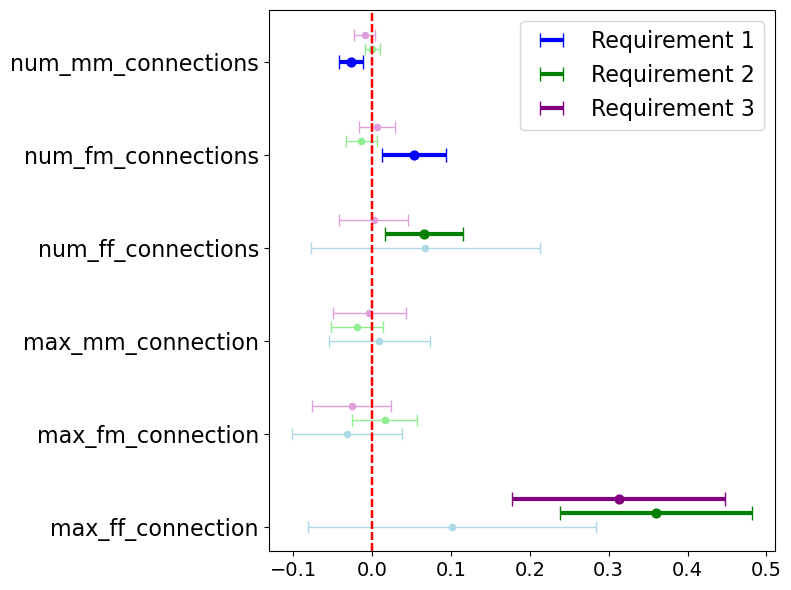

In [243]:
fig, axs = plt.subplots(figsize=(8, 6))

labels, coefs, intervals = subset_plotdata(unsig_coefs1, unsig_intervals1, plottype='connection')
coefplot(coefs, intervals, labels, axs, None, bold=False, color='lightblue')

labels, coefs, intervals = subset_plotdata(sig_coefs1, sig_intervals1, plottype='connection')
coefplot(coefs, intervals, labels, axs, "Requirement 1", bold=True, color='blue')

labels, coefs, intervals = subset_plotdata(unsig_coefs2, unsig_intervals2, plottype='connection')
labels = np.array(labels) + 0.15
coefplot(coefs, intervals, labels, axs, None, bold=False, color='lightgreen')

labels, coefs, intervals = subset_plotdata(sig_coefs2, sig_intervals2, plottype='connection')
labels = np.array(labels) + 0.15
coefplot(coefs, intervals, labels, axs, "Requirement 2", bold=True, color='green')

labels, coefs, intervals = subset_plotdata(unsig_coefs3, unsig_intervals3, plottype='connection')
labels = np.array(labels) + 0.3
coefplot(coefs, intervals, labels, axs, None, bold=False, color='plum')

labels, coefs, intervals = subset_plotdata(sig_coefs3, sig_intervals3, plottype='connection')
labels = np.array(labels) + 0.3
coefplot(coefs, intervals, labels, axs, "Requirement 3", bold=True, color='purple')


axs.set_yticks(list(connections_key.values()), fontsize=16)
axs.set_yticklabels(list(connections_key.keys()), fontsize=16)
axs.legend(prop={'size': 16})

[item.set_fontsize(14) for item in axs.get_xticklabels()]
#[item.set_fontsize(12) for item in axs.get_yticklabels()]


plt.tight_layout()
fig.savefig("connection_coefs.png")
plt.show()

<AxesSubplot:>

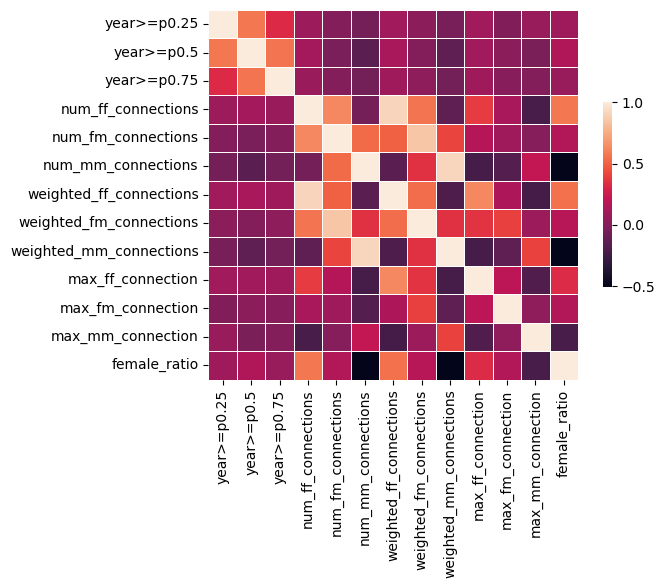

In [180]:
#movie_data[conn_columns].corr()

#sns.heatmap(movie_data[conn_columns].corr(), #mask=mask, cmap=cmap, vmax=.3, center=0,
#            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [171]:
# powell converges but has runtime errors like overflow and divide by zero
"""
log_reg1 = sm.Logit(pd_bechdel_labels['P>0'], sm.add_constant(movie_data[conn_columns])).fit(method='ncg', maxiter=100)
log_reg2 = sm.Logit(pd_bechdel_labels[pd_bechdel_labels['P>0'] == 1]['P>1'], 
                    sm.add_constant(movie_data[movie_data['rating'] > 0][conn_columns])).fit(method='ncg', maxiter=100)
log_reg3 = sm.Logit(pd_bechdel_labels[pd_bechdel_labels['P>1'] == 1]['P>2'], 
                    sm.add_constant(movie_data[movie_data['rating'] > 1][conn_columns])).fit(method='ncg', maxiter=100)

acc, preds = model_accuracy(log_reg1, log_reg2, log_reg3, sm.add_constant(movie_data[conn_columns]), ratings)
acc
"""

Optimization terminated successfully.
         Current function value: 0.204105
         Iterations: 17
         Function evaluations: 20
         Gradient evaluations: 20
         Hessian evaluations: 17
Optimization terminated successfully.
         Current function value: 0.516579
         Iterations: 23
         Function evaluations: 32
         Gradient evaluations: 32
         Hessian evaluations: 23
Optimization terminated successfully.
         Current function value: 0.457066
         Iterations: 21
         Function evaluations: 29
         Gradient evaluations: 29
         Hessian evaluations: 21


0.5733558178752108

In [174]:
log_reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    P>2   No. Observations:                  364
Model:                          Logit   Df Residuals:                      350
Method:                           MLE   Df Model:                           13
Date:                Mon, 28 Nov 2022   Pseudo R-squ.:                  0.2038
Time:                        01:33:50   Log-Likelihood:                -166.37
converged:                       True   LL-Null:                       -208.97
Covariance Type:            nonrobust   LLR p-value:                 1.152e-12
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.0697      0.784      1.365      0.172      -0.466       2.605
year>=p0.25                 0.0759      0.350      0.217      0.828      -0.610       0.762
year>=p0.5                  0.4673      0.378      1.236      0.216      -0.274       1.208
year>=p0.75                 0.1266      0.444      0.285      0.776      -0.744       0.997
num_ff_connections         -0.2208      0.075     -2.946      0.003      -0.368      -0.074
num_fm_connections         -0.0254      0.021     -1.207      0.227      -0.067       0.016
num_mm_connections          0.0126      0.013      0.968      0.333      -0.013       0.038
weighted_ff_connections     0.1930      0.065      2.988      0.003       0.066       0.320
weighted_fm_connections     0.0245      0.014      1.764      0.078      -0.003       0.052
weighted_mm_connections    -0.0129      0.008     -1.695      0.090      -0.028       0.002
max_ff_connection          -0.0373      0.112     -0.334      0.738      -0.256       0.182
max_fm_connection          -0.0668      0.034     -1.986      0.047      -0.133      -0.001
max_mm_connection           0.0073      0.028      0.260      0.795      -0.048       0.062
female_ratio               -1.5219      1.790     -0.850      0.395      -5.031       1.987
===========================================================================================
"""